**Feature Engineering**
==========
모델에 직접 적용하기 전에 데이터들을 분석하고 이를 training하기 좋게 변환하는 과정이 중요하다 생각하여 하는 과정임 - Sina의 Kernel 참조하였음

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('C:/Users/sangkyu/git/kaggle/titanic/input/train.csv')
test = pd.read_csv('C:/Users/sangkyu/git/kaggle/titanic/input/test.csv')
full_data = [train,test]

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [4]:
# Null값들을 -1로 바꾸고 14세 이하인 사람들을 Minor라는 새로운 feature를 만들어서 저장하였다.
for dataset in full_data:
    dataset['Age_copy'] = dataset['Age'].fillna(-1)
    dataset['Minor'] = (dataset['Age_copy'] < 14.0) & (dataset['Age_copy']>= 0)
    dataset['Minor'] = dataset['Minor'] * 1 # 1곱하면 True,False를 숫자형으로 바꿀수 있음

In [5]:
train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean()
# as_index=True로 설정하게되면 보기 불편하게 되어있음

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train[['SibSp','Survived']].groupby(['SibSp'],as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [8]:
train[['Parch','Survived']].groupby(['Parch'],as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [9]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train[['FamilySize','Survived']].groupby(['FamilySize'],as_index=False).mean()
# FamilySize라는 Feature가 언뜻보면 생존에 영향을 끼치는 것 같기도 하다.

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [10]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1,'IsAlone']=1
train[['IsAlone','Survived']].groupby(['IsAlone'],as_index=False).mean()
# 혼자 배에 탔는지 안탔는지가 영향을 주는 것 같아 보인다.

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [11]:
# 어렵게 생각하지않고 Missing Value를 최빈값으로 채워 넣어야겠다.
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [12]:
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# pd.qcut -> 동일한 개수로 나누기
train[['CategoricalFare','Survived']].groupby(['CategoricalFare'],as_index=False).mean()
# 높은 운임을 낸 사람이 조금 더 살아남은것으로 보임

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [13]:
train['Name']
# 보면 이름이 중구난방으로 적혀있어...어떻게할까? 보면 Mr,Miss,Master,Mrs,Rev등으로 나누어짐
# 나는 외국이름을 나누는데 어떻게 나눠야할지 모르겠어..

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [14]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) or re.search(' ([A-Za-z]+).', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))


# 이름중에서 성만 따로 추출해서 'Title'이라는 새로운 Column을 만듬

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [15]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Capt','Col','Countess','Don','Dr','Jonkheer','Major',
                                                'Rev','Sir','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    
train[['Title','Survived']].groupby(['Title'],as_index=False).mean()

# 사람이 타이핑 하면서 오타가 난것들을 바꾸어주고 흔하지 않은 성을 Rare로 하나로 묶어 Survived와의 관계를 확인 하였다


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [16]:
for dataset in full_data:
    # 'Sex' : 여자를 1 남자를 0으로 매핑하자
    dataset['Sex'] = dataset['Sex'].replace('female',0)
    dataset['Sex'] = dataset['Sex'].replace('male',1)
    # 'Title' : 5개로 나누어진 'Title'변수를 숫자로 매핑함
    dataset['Title'] = dataset['Title'].replace('Master',1)
    dataset['Title'] = dataset['Title'].replace('Miss',2)
    dataset['Title'] = dataset['Title'].replace('Mr',3)
    dataset['Title'] = dataset['Title'].replace('Mrs',4)
    dataset['Title'] = dataset['Title'].replace('Rare',5)

    # 'Embarked' C,Q,S로 나누어져있음 이걸 숫자로 매핑하자
    dataset['Embarked'] = dataset['Embarked'].replace('C',0)
    dataset['Embarked'] = dataset['Embarked'].replace('Q',1)
    dataset['Embarked'] = dataset['Embarked'].replace('S',2)
    # 'Fare' 구간을 숫자로 매핑하자
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare']<= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare']<= 31.0), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31.0, 'Fare'] = 3
    
# Feature들중에서 필요없는건 지우고 필요한건 선택하여 train set을 완성하자.
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',
                 'Parch', 'FamilySize','Age']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)
print(train.shape)
print(test.shape)

(891, 9)
(418, 8)


In [17]:
train[['Fare','Survived','Pclass']].groupby(['Fare','Pclass'],as_index=False).mean()

,Fare,Pclass,Survived
0,0.0,1,0.000000
1,0.0,2,0.000000
2,0.0,3,0.208531
3,1.0,2,0.383721
4,1.0,3,0.259542
5,2.0,1,0.529412
6,2.0,2,0.600000
7,2.0,3,0.305556
8,3.0,1,0.685535
9,3.0,2,0.545455


In [18]:
train.head()

,Survived,Pclass,Sex,Fare,Embarked,Age_copy,Minor,IsAlone,Title
0,0,3,1,0.0,2,22.0,0,0,3
1,1,1,0,3.0,0,38.0,0,0,4
2,1,3,0,1.0,2,26.0,0,1,2
3,1,1,0,3.0,2,35.0,0,0,4
4,0,3,1,1.0,2,35.0,0,1,3


In [19]:
test.fillna(test.mean(),inplace=True)

In [20]:
X=train.drop(columns=['Survived'],axis=1)
y=train['Survived']

In [21]:
X.shape, y.shape

((891, 8), (891,))

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
y_pred = rf.predict(X_val) 
rf.score(X_val,y_val)

0.7653631284916201

In [25]:
rf.feature_importances_
from pandas import Series
feature_importance = rf.feature_importances_
Series_feat_imp = Series(feature_importance, index=test.columns)

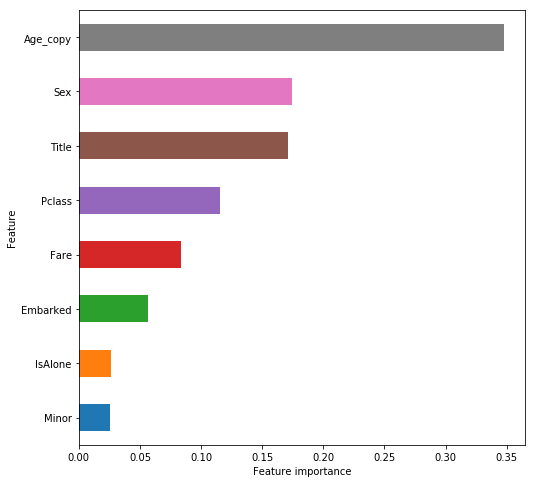

In [26]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [27]:
from pprint import pprint
# 랜덤포레스트에서 사용하는 parameter들 확인.
pprint(rf.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [28]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [29]:
random_grid = { 
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth' : max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [30]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,n_iter=100,
                              cv=3,verbose=2,random_state=42,
                              n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2

In [31]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [32]:
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [20,30,40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [800,900,1000,1100]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf,param_grid = param_grid,
                          cv=5,n_jobs=-1,verbose=2)

In [33]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'max_depth': [20, 30, 40], 'max_features': ['sqrt'], 'min_samples_leaf': [2], 'min_samples_split': [2], 'n_estimators': [800, 900, 1000, 1100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [34]:
best_grid = grid_search.best_estimator_

In [35]:
best_grid.fit(X_train,y_train)
best_grid.score(X_val,y_val)

0.8100558659217877

In [36]:
test_2 = pd.read_csv('C:/Users/sangkyu/git/kaggle/titanic/input/test.csv')

In [37]:
rf_pred=best_grid.predict(test)
rf_X_pred=best_grid.predict(X_val)

In [38]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, rf_X_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8001930501930502

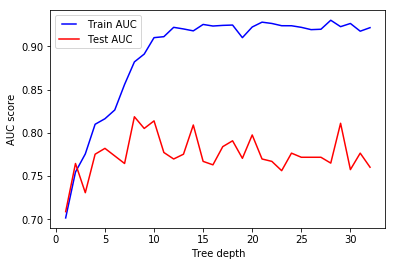

In [39]:
import matplotlib.pyplot as plt
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = RandomForestClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_val)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
# train셋에 overfitting된걸 볼 수 있음.
# overffiting을 방지하기 위해선 적은수의 parameter를 사용해야한다
# 또한 모델의 hyperparameter들을 바꿔서 줄일 수 있다
# regularization 하면된다
# 더많은 training data를 사용하면된다.



In [40]:
result = pd.DataFrame(test_2['PassengerId'])
result['Survived']= rf_pred

In [41]:
result.to_csv('submission13.csv', index=False)